## ３章のkeras版


### 前準備

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import random
from IPython.display import Image
%matplotlib inline

# keras用のパッケージをインポート
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers

Using TensorFlow backend.


### 環境の引用
３章で使われているゲームは、4x4のマス目に
- A: エージェント
- W: 壁
- -: ピット
- +: ゴール

を配置し、エージェントが壁を避けて最短でゴールに到着させるゲームです。

３章の図3.1からゲームの画面を引用します。

<img src="images/fig3.1.png" width="300"/>

### ゲームの引用
Deep Reinforcement Learning in ActionのgithubサイトからGridBoard.py, Gridworld.pyを引用し、scriptディレクトリに配置しました。

In [2]:
from script.Gridworld  import *

## 強化学習の手順
バリュー関数は、以下のように定義します。

$$
V_{\pi}(s) = \Sigma_{i=1}^t w_i R_i = w_1 R_1 + w_2 R_2 + \dots+ w_t R_t
$$


同様にアクション・バリュー関数 $Q_{\pi}(s, a)$ は、以下ように更新されます。

$$
Q_{\pi}(S_{t+1}, A_{t}) = Q_{\pi}(S_t, A_t) + \alpha \left [ R_{t+1} + \gamma \, max \, Q(S_{t+1}, a) - Q(S_t, A_t) \right ]
$$

ここで、各変数は以下のように定義されています。
- $Q_{\pi}(S_{t+1}, A_{t}) $: 更新されたQ値
- $Q_{\pi}(S_t, A_t)$: 現在のQ値
- $\alpha$: ステップサイズ
- $\gamma$: 減衰ファクタ
- $max \, Q(S_{t+1}, a) $: すべてのアクションでの最大のQ値

### Qネットワークの更新
Qネットワークの更新は、以下のフローで行います。

In [3]:
%%bash
dot -Tpng -Gdpi=200 models/fig_3_3.dot> images/fig_3_3.png

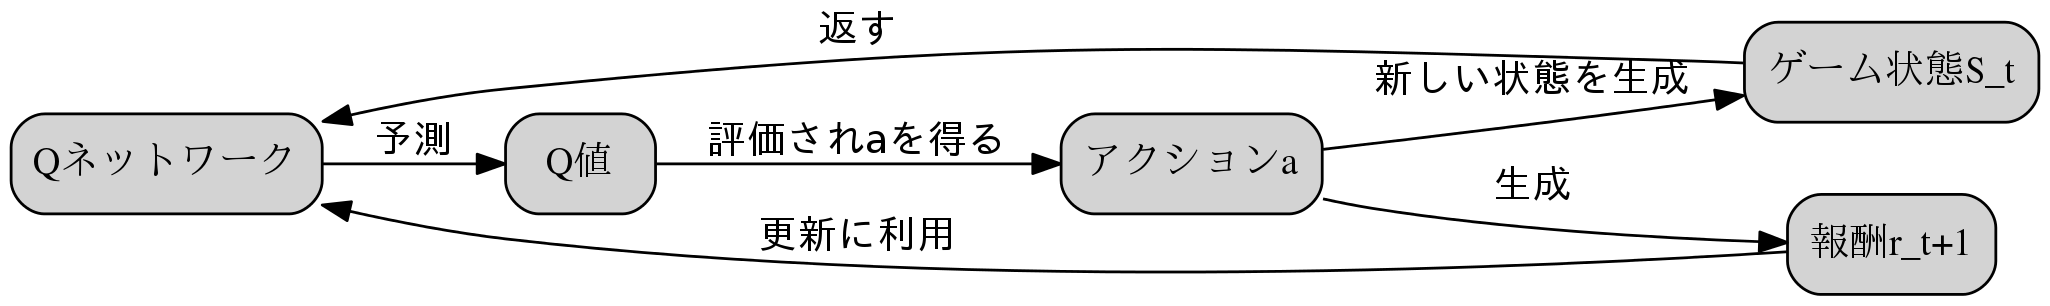

In [4]:
Image("images/fig_3_3.png")

### ゲームの動き


In [5]:
game = Gridworld(size=4, mode='static')
game.display()

array([[u'+', u'-', u' ', u'P'],
       [u' ', u'W', u' ', u' '],
       [u' ', u' ', u' ', u' '],
       [u' ', u' ', u' ', u' ']], 
      dtype='<U2')

In [6]:
game.makeMove('d')
game.makeMove('d')
game.makeMove('l')
game.display()

array([[u'+', u'-', u' ', u' '],
       [u' ', u'W', u' ', u' '],
       [u' ', u' ', u'P', u' '],
       [u' ', u' ', u' ', u' ']], 
      dtype='<U2')

In [7]:
game.board.render_np()

array([[[0, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0]],

       [[0, 1, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[1, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

render_npでは、Wall, Player, Goal, Pitの配置が1で表された4x4の配列がそれぞれ返されます。

図3.6から配置のイメージを引用します。

<img src="images/fig3.6.png" width="300" />


### ニューラルネットモデル


In [8]:
D_in, H1, H2, D_out = 64, 150, 100, 4
learning_rate = 1e-3

def createModel(learning_rate=learning_rate):
    model = Sequential()
    model.add(Dense(H1, activation='relu', input_dim=D_in))
    model.add(Dense(H2, activation='relu'))
    model.add(Dense(D_out))
    optimizer = optimizers.Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    return model

model = createModel()

action_set = {
    0: 'u',
    1: 'd',
    2: 'l',
    3: 'r',
}

In [9]:
# ゲームのインスタンスを生成
# 最初に固定（static）のゲームを使って学習
game = Gridworld(mode='static')

In [10]:
gamma = 0.9
epsilon = 0.05
tau = .05
# ゲームのシニュレーションをする環境を準備
class SimulationEnv:
    def __init__(self, model, game, epsilon, depsilon=0.05, gamma=0.9):
        self.model = model
        self.game = game
        self.epsilon = epsilon
        self.depsilon = depsilon
        self.gamma = gamma
        # おそらくデータが極端にスパースになるのを防ぐためではないかと推測
        self.noise_rate = 1.0/10.0
        # 出力層の次元
        self.D_out = int(self.model.weights[-1].shape[0])
        self.curState = self.state()
    
    # 現在のゲームの状態を返す
    def state(self):
        state = self.game.board.render_np().reshape(1,64) + np.random.rand(1,64)*self.noise_rate
        return state
    
    # アクションを(state, action)を返す
    def sample(self):
        # Q値の確率
        Qprob = self.model.predict(self.curState)[0]
        if random.random() < self.epsilon :
            action = np.random.randint(0,self.D_out)
        else:
            action = np.argmax(Qprob)
        return (action, Qprob)
    
    # 次のステップに進み、(state, action, newState, reward, Qprob, done)のタプルを返す
    def step(self, action):
        state = self.curState
        (action, Qprob) = self.sample()
        # ゲームのPersonを移動
        self.game.makeMove(action_set[action])
        reward = self.game.reward()
        done = reward != -1
        newState = self.state()
        self.curState = newState
        return (state, action, newState, reward, Qprob, done)
    
    def update(self, state, action, newState, reward, Qprob, done):
        newQprob = self.model.predict(newState)[0]
        maxQprob = np.max(newQprob)
        y = np.zeros((1, 4))
        y[:] = Qprob[:]
        if not done:
            update = (reward + (gamma * maxQprob))
        else:
            update = reward
        y[0][action] = update
        ret = self.model.fit(state.reshape(1, 64), y, epochs=1, batch_size=1, verbose=0)
        return ret.history['loss']

In [11]:
epsilon = 1.0
epochs = 1000
losses = []
for i in range(epochs):    
    game = Gridworld(mode='static')
    env = SimulationEnv(model, game, epsilon)
    done = False
    while not done:
        action, Qprob = env.sample()
        state, action, newState, reward, Qprob, done = env.step(action)
        loss = env.update(state, action, newState, reward, Qprob, done)
        losses += loss
    if epsilon > 0.1:
        epsilon -= (1.0/epochs)

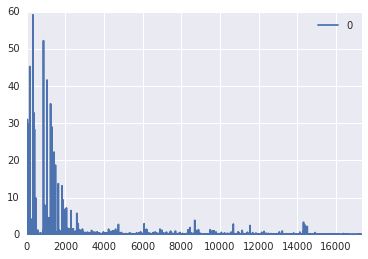

In [17]:
import seaborn as sns
import pandas as pd

d = pd.DataFrame(losses)
# loss,をプロット
sns.set()
d.plot()
plt.show()

In [15]:
# モデルを検証するためのメソッド
def testModel(model, mode='static', display=True):
    def display(env, msg):
        print(msg)
        print(game.display())
        
    epsilon = 0.05
    max_moves = 50
    win = False
    i = 0
    game = Gridworld(mode=mode)
    env = SimulationEnv(model, game, epsilon)
    if display: 
        display(env, 'initial State:')
    status = 1
    #while game still in progress
    while(status == 1):
        action, Qprob = env.sample()
        if display: 
            display(env, 'Move #: %s; Taking action: %s' % (i, action_set[action]))
        state, action, newState, reward, Qprob, done = env.step(action)
        if reward != -1:
            status = 0
            print('Reward: %s' %(reward, ))
        i += 1
        if i > max_moves:
            print("Game lost; too many moves.")
            break       

In [16]:
testModel(model, 'static')

initial State:
[[u'+' u'-' u' ' u'P']
 [u' ' u'W' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 0; Taking action: d
[[u'+' u'-' u' ' u'P']
 [u' ' u'W' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 1; Taking action: l
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u'P']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 2; Taking action: d
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u'P' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 3; Taking action: l
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u' ']
 [u' ' u' ' u'P' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 4; Taking action: l
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u' ']
 [u' ' u'P' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 5; Taking action: u
[[u'+' u'-' u' ' u' ']
 [u' ' u'W' u' ' u' ']
 [u'P' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Move #: 6; Taking action: u
[[u'+' u'-' u' ' u' ']
 [u'P' u'W' u' ' u' ']
 [u' ' u' ' u' ' u' ']
 [u' ' u' ' u' ' u' ']]
Reward: 10


## スタティック版

## ランダム版

## 経験再現版

### ターゲット・ネットワークの導入